This tutorial covers [linear regression](https://en.wikipedia.org/wiki/Linear_regression).  Linear regression attempts to fit a line of best fit to a data set, using one or more features as coefficients for a linear equation.  Here, We'll discuss:

 - Loading, manipulating and plotting data using numpy and matplotlib
 - The hypothesis and cost functions for linear regression
 - Gradient descent with one variable and multiple variables
 - Feature scaling and normalization
 - Vectorization and the normal equation
 
In this post, I'm using the [UCI Bike Sharing Data Set](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

# Loading and Plotting Data

For the first part, we'll be doing linear regression with one variable, and so we'll use only two fields from the daily data set: the normalized high temperature in Celcius, and the total number of bike rentals.  The values for rentals are scaled by a factor of a thousand, given the  difference in magnitude between them and the normalized temperatures.

In [1]:
import pandas as pd

data = pd.read_csv("https://raw.githubusercontent.com/SanVik2000/EE5180-Tutorials/main/Tutorial-2/data.csv")
temps = data['atemp'].values
rentals = data['cnt'].values / 1000

The plot reveals some degree of correlation between temperature and bike rentals, as one might guess.

Text(0, 0.5, 'Bike Rentals in 1000s')

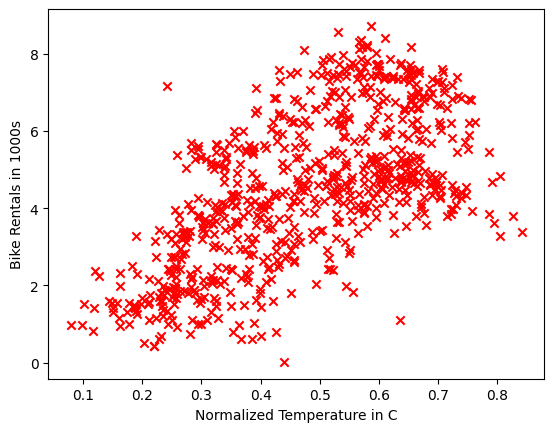

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(temps, rentals, marker='x', color='red')
plt.xlabel('Normalized Temperature in C')
plt.ylabel('Bike Rentals in 1000s')

# Simple Linear Regression

We'll start by implementing the [cost function](https://en.wikipedia.org/wiki/Loss_function) for linear regression, specifically [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE).  Intuitively, MSE represents an aggregation of the distances between point's actual y value and what a hypothesis function $h_\theta(x)$ predicted it would be.  That hypothesis function and the cost function $J(\theta)$ are defined as

\begin{align}
h_\theta(x) & = \theta_0 + \theta_1x_1 \\
J(\theta) & = \frac{1}{2m}\sum\limits_{i = 1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2
\end{align}

where $\theta$ is a vector of feature weights, $x^{(i)}$ is the ith training example, $y^{(i)}$ is that example's y value, and $x_j$ is the value for its jth feature.

In [3]:
import numpy as np

def compute_cost(X, y, theta):
    return np.sum(np.square(np.matmul(X, theta) - y)) / (2 * len(y))

Before computing the cost with an initial guess for $\theta$, a column of 1s is prepended onto the input data.  This allows us to vectorize the cost function, as well as make it usable for multiple linear regression later.  This first value $\theta_0$ now behaves as a constant in the cost function.

In [4]:
print("Temps Shape : " , temps.shape)
print("Rentals Shape : " , rentals.shape)

theta = np.zeros(2)
X = np.column_stack((np.ones(len(temps)), temps))
y = rentals
cost = compute_cost(X, y, theta)

print('-----------------')
print("X Shape : ", X.shape)
print("Y Shape : ", y.shape)
print('-----------------')
print("X : ", X)
print('-----------------')
print('theta:', theta)
print('cost:', cost)

Temps Shape :  (731,)
Rentals Shape :  (731,)
-----------------
X Shape :  (731, 2)
Y Shape :  (731,)
-----------------
X :  [[1.       0.363625]
 [1.       0.353739]
 [1.       0.189405]
 ...
 [1.       0.2424  ]
 [1.       0.2317  ]
 [1.       0.223487]]
-----------------
theta: [0. 0.]
cost: 12.018406441176468


We'll now minimize the cost using the [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) algorithm.  Intuitively, gradient descent takes small, linear hops down the slope of a function in each feature dimension, with the size of each hop determined by the partial derivative of the cost function with respect to that feature and a learning rate multiplier $\alpha$.  If tuned properly, the algorithm converges on a global minimum by iteratively adjusting feature weights $\theta$ of the cost function, as shown here for two feature dimensions:

\begin{align}
\theta_0 & := \theta_0 - \alpha\frac{\partial}{\partial\theta_0} J(\theta_0,\theta_1) \\
\theta_1 & := \theta_1 - \alpha\frac{\partial}{\partial\theta_1} J(\theta_0,\theta_1) 
\end{align}

The update rule each iteration then becomes:

\begin{align}
\theta_0 & := \theta_0 - \alpha\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)}) \\
\theta_1 & := \theta_1 - \alpha\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_1^{(i)} \\
\end{align}

See [here](http://mccormickml.com/2014/03/04/gradient-descent-derivation/) for a more detailed explanation of how the update equations are derived.

In [5]:
def gradient_descent(X, y, alpha, iterations):
    theta = np.zeros(2)
    m = len(y)
    
    for i in range(iterations):
        t0 = theta[0] - (alpha / m) * np.sum(np.dot(X, theta) - y)
        t1 = theta[1] - (alpha / m) * np.sum((np.dot(X, theta) - y) * X[:,1])
        theta = np.array([t0, t1])

    return theta

iterations = 5000
alpha = 0.1

theta = gradient_descent(X, y, alpha, iterations)
cost = compute_cost(X, y, theta)

print("theta:", theta)
print('cost:', compute_cost(X, y, theta))

theta: [0.94588081 7.50171673]
cost: 1.1275869258439812


We can examine the values of $\theta$ chosen by the algorithm using a few different visualizations, first by plotting $h_\theta(x)$ against the input data.  The results show the expected correlation between temperature and rentals.

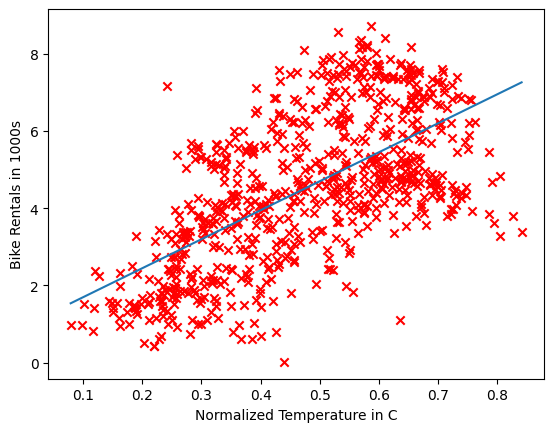

In [6]:
plt.scatter(temps, rentals, marker='x', color='red')
plt.xlabel('Normalized Temperature in C')
plt.ylabel('Bike Rentals in 1000s')
samples = np.linspace(min(temps), max(temps))
plt.plot(samples, theta[0] + theta[1] * samples)

A surface plot is a better illustration of how gradient descent approaches a global minimum, plotting the values for $\theta$ against their associated cost.

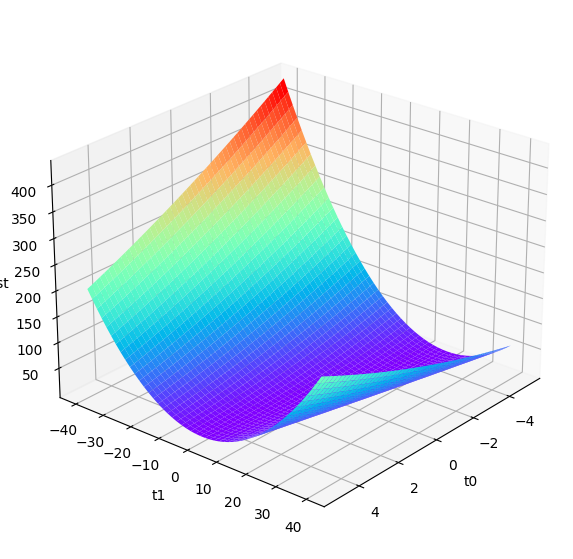

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

Xs, Ys = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-40, 40, 50))
Zs = np.array([compute_cost(X, y, [t0, t1]) for t0, t1 in zip(np.ravel(Xs), np.ravel(Ys))])
Zs = np.reshape(Zs, Xs.shape)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel(r't0')
ax.set_ylabel(r't1')
ax.set_zlabel(r'cost')
ax.view_init(elev=25, azim=40)
ax.plot_surface(Xs, Ys, Zs, cmap=cm.rainbow)

# Multiple Linear Regression

First, we reload the data and add two more features, humidity and windspeed.

Before implementing gradient descent for multiple variables, we'll also apply [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) to normalize feature values, preventing any one of them from disproportionately influencing the results, as well as helping gradient descent converge more quickly.  In this case, each feature value is adjusted by subtracting the mean and dividing the result by the standard deviation of all values for that feature:

$$
z = \frac{x - \mu}{\sigma}
$$

More details on feature scaling and normalization can be found [here](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html).

In [ ]:
def feature_normalize(X):
    n_features = X.shape[1]
    #Compute Mean
    means = np.array([np.mean(X[:,i]) for i in range(n_features)])
    
    #Compute Standard Deviation
    stddevs = #Fill Code Here
    
    normalized = #Fill Code Here
    
    return normalized

X = data[['atemp', 'hum', 'windspeed']].values
X = feature_normalize(X)
X = np.column_stack((np.ones(len(X)), X))

y = data['cnt'].values / 1000

The next step is to implement gradient descent for any number of features.  Fortunately, the update step generalizes easily, and can be vectorized to avoid iterating through $\theta_j$ values as might be suggested by the single variable implementation above:

$$
\theta_j := \theta_j - \alpha\frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}
$$

In [ ]:
def gradient_descent_multi(X, y, theta, alpha, iterations):
    #Fill Code Here
    theta = 
    m = len(X)

    for i in range(iterations):
        gradient = 
        theta = 

    return theta

theta = gradient_descent_multi(X, y, theta, alpha, iterations)
cost = compute_cost(X, y, theta)

print('theta:', theta)
print('cost', cost)

Let us verify our solution using the [normal equation](http://eli.thegreenplace.net/2014/derivation-of-the-normal-equation-for-linear-regression/).  This solves directly for the solution without iteration specifying an $\alpha$ value, although it begins to perform worse than gradient descent with large (10,000+) numbers of features.

$$
\theta = (X^TX)^{-1}X^Ty
$$

In [ ]:
from numpy.linalg import inv

def normal_eq(X, y):
    return # Fill Code Here

theta = normal_eq(X, y)
cost = compute_cost(X, y, theta)

print('theta:', theta)
print('cost:', cost)

# Polynomial Regression

\begin{align}
h_\theta(x) & = \theta_0 + \theta_1x + \theta_2x^2 + .. + \theta_nx^n \\
J(\theta) & = \frac{1}{2m}\sum\limits_{i = 1}^{m}(h_\theta(x^{(i)}) - y^{(i)})^2
\end{align}

\begin{align}
\theta_0 & := \theta_0 - \alpha\frac{\partial}{\partial\theta_0} J(\theta_0,\theta_1, .. , \theta_n) \\
\theta_1 & := \theta_1 - \alpha\frac{\partial}{\partial\theta_1} J(\theta_0,\theta_1, .. , \theta_n) \\
. \\
. \\
. \\
\theta_n & := \theta_n - \alpha\frac{\partial}{\partial\theta_n} J(\theta_0,\theta_1, .. , \theta_n)
\end{align}

The update rule each iteration then becomes:

\begin{align}
\theta_0 & := \theta_0 - \alpha\frac{1}{m} \sum_{i=1}^m (h_\theta(x_{(i)})-y_{(i)}) \\
\theta_1 & := \theta_1 - \alpha\frac{1}{m} \sum_{i=1}^m (h_\theta(x_{(i)})-y_{(i)})x_{(i)} \\
. \\
. \\
. \\
\theta_1 & := \theta_1 - \alpha\frac{1}{m} \sum_{i=1}^m (h_\theta(x_{(i)})-y_{(i)})x_{(i)}^2
\end{align}

In [ ]:
# Implement Polynomial Regression with degree=2 (Quadratic) and degree=3 (Cubic) and write your observations